<p style="violet"> Set up modules (standard and mine) </b>

In [156]:
### Import Standard Packages ###
import matplotlib.pyplot as mp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np
import metpy.calc as mpc
import metpy.constants as mconst
import xarray as xr
import scipy as spy
import pandas as pd
import datetime as dt
import cartopy

#dir(mconst)
### My Functions ###
import scam_func as mypy
import importlib


#%xmode Plain   ## Fortran-like error tracebacks (doesn't seem to work though)

<b> Add Experiment Set </b>

In [168]:
#### SCRIPT TO READ IN SCAM OUTPUT AND MAKE SOME PLOTS ####
###### IOP file info. ######

#xr.show_versions()


## Multiple cases ##

#scam_file_nums = ['011a','011b','011c','011d']  # For comparisons
#scam_file_nums = ['012a','012b','012c','012d','012e','012f']  # For comparisons
#scam_file_nums = ['012a','012b','012f']
#scam_run_names = ['q_ft','0.5LS.T','no LS.Tq']

#scam_run_names = ['q_ft','0.5LS.T','0.5LS.q','0.5LS.Tq','0.25LS.Tq','no LS.Tq']

## Vertical resolution ##
#scam_file_nums = ['100a','100','100b','100c']
#scam_file_nums = ['101a','101','101b','101c','101d'] # 'a'=L16, ''=L32
#scam_run_names = ['L16','L32','L64','L128','L256']

#scam_file_nums = ['102a','102','102b','102c'] # 'a'=L15, ''=L30
#scam_run_names = ['L15','L30','L60','L120']


#scam_file_nums = ['101','102'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6','CAM5']


#scam_file_nums = ['101def','102def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 default','CAM5 default']

#scam_file_nums = ['101','101def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 2 min','CAM6']

#scam_file_nums = ['102','102def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM5 2 min','CAM5']

#scam_file_nums = ['101','102'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 2 min','CAM5 2 min']

#scam_file_nums = ['101d','101dx'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 until 4pm','CAM6 until 11:30pm']

#scam_file_nums = ['101d','201d','202d'] # 'a'=L16, ''=L32
#scam_run_names = ['gamma_coef=0.308','gamma_coef=0.285','gamma_coef=0.345']

### WITH LES ###

#scam_file_nums = np.array(['101d','203d','204d','LES']) # 'a'=L16, ''=L32
#scam_run_names = ['clubb_c_k10=0.5','clubb_c_k10=0.3','clubb_c_k10','LES']

#scam_file_nums = ['101a','101','101b','101c','101d']# 'a'=L16, ''=L32
#scam_run_names = ['L16','L32','L64','L128','L256']

#scam_file_nums = ['106','106d','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L32','CAM6-L256','NCAR']


scam_file_nums = ['106def','106d','LES'] # ''=L16, ''=L32
scam_run_names = ['CAM6','CAM6-L256-2min','NCAR']

#scam_file_nums = ['106c','106c.cam5','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L128','CAM5-L120','NCAR']

#scam_file_nums = ['106a','106','106b','106c','106d','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L16','CAM6-L32','CAM6-L64','CAM6-L128','CAM6-L256','NCAR']

#scam_file_nums = ['105d','LES','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6','CAM6->LES','NCAR']




scam_file_pre = "FSCAM.T42_T42.SAS."
scam_file_suf = ".cam.h0.2013-06-10-39600"
#scam_file_suf = ".cam.h0.2013-06-10-43200"

#scam_files_in = [scam_file_pre+x+scam_file_suf for x in scam_file_nums]
#scam_files_in = np.where()

#print(scam_files_in)
#scam_file_suf = ".cam.h0.2013-06-10-43200"

# LES model selections.

les_files_in = {}
les_files_in['NCAR'] = "patton_sas_stats.nc"


### Construct filenames ### 

scam_files_in = np.empty_like(scam_file_nums)
scam_file_nums = np.array(scam_file_nums) 
scam_run_names = np.array(scam_run_names) 


# Standard SCAM
scam_files_in = ['history/'+scam_file_pre+x+scam_file_suf+'.nc' for x in scam_file_nums] 

# SCAM in SAS-LES format
ii = [ix for ix, x in enumerate(scam_file_nums) if x == 'LES']# Change to LES-SAS-format file if needed 
for i in ii: scam_files_in[i] = 'history/'+scam_file_pre+scam_file_nums[0]+scam_file_suf+'_SAS_format.nc' 

# LES in SAS-LES format
scam_files_in = np.where(scam_run_names == 'NCAR','LES/'+les_files_in['NCAR'],scam_files_in) # Change to LES file if needed
#scam_files_in = np.where(scam_run_names == 'FAST_EDDY','LES/'+les_files_in['FAST_EDDY'],scam_files_in) # Change to LES file if needed



print(scam_files_in)

#les_file_in = "LES/FSCAM.T42_T42.SAS.LES.cam.h0.2013-06-10-39600_SAS_format.nc"


['history/FSCAM.T42_T42.SAS.106def.cam.h0.2013-06-10-39600.nc'
 'history/FSCAM.T42_T42.SAS.106d.cam.h0.2013-06-10-39600.nc'
 'LES/patton_sas_stats.nc']


<b> Diagnostic Field Selections </b>

In [169]:
#### PLOTTING ####

### 1D TS ### 

#pvars_ts1d = np.array(['PBLH','TS','LHFLX','SHFLX','PRECC','PRECL','FLNS']) # D profile timeseries plots
#pvars_ts2d = ['DTV','VD01','DCQ','Q','T','TH','THL']
pvars_ts1d = np.array(['SHFLX','LHFLX','PBLH','PBLH_DQ'])



### 2D TS ###
                       ## WPSKEW is WP3_CLUBB/WP2_CLUBB**3/2
#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT', 
#            'STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','WP3_CLUBB','THLP2_CLUBB','WP2_CLUBB'] # 2D profile timeseries plots
#pvars_ts2d = ['WPRTP_CLUBB','Q','TH']
#pvars_ts2d = ['DTV','VD01','DCQ','Q','T','TH','THL']
pvars_ts2d = ['THV','TH','Q','WP2_CLUBB','WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB']




### 1D SNAPSHOT ###

#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']

#pvars_ts2d = ['STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB'] 
    
#pvars_snap = ['STEND_CLUBB','RVMTEND_CLUBB','TH','THL','Q','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB']  # Snapshot plotting vars
#pvars_snap = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']
#pvars_snap = ['TH','THL','Q','RELHUM','DTV','DCQ','STEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB']
pvars_snap = ['TH','Q']

              
pvars_anim = np.array(('Q'))

tsnaps = np.array([6.,8.,10.,12.,14.,16])     # Time of snapshots (local time)


### Bundle these array for pasing to functions ###
run_info = {}
run_info['1dvars'] = pvars_ts1d
run_info['2dvars'] = pvars_ts2d
run_info['snapvars'] = pvars_snap

####### GRAPHICS ########
#mp.interactive(True)
#%matplotlib qt
#%matplotlib inline

<b> Files Setups </b>

In [170]:
#### CONSTANTS #####

r_gas = mconst.dry_air_gas_constant.magnitude   # Specific gas constant for dry air
cp_air = mconst.dry_air_spec_heat_press.magnitude # Specific heat for dry air
Lv = mconst.water_heat_vaporization.magnitude       # Latent heat of vaporization

r_cp = r_gas/cp_air    # r/cp
grav = mconst.earth_gravity.magnitude       # Gravity ave.
p0 = mconst.pot_temp_ref_press.magnitude


####### DERIVED VARS #######



print('++++ Runs ++++')
print('')
#scam_files_in = scam_file_pre+scam_file_nums+scam_file_suf 
scam_fig_stub='png/'+'_'.join(scam_file_nums)

zoffset = 6.  # Offset for Z time.
### Bundle run info ###

run_info['Run Name']   = scam_run_names
run_info['File Num']   = scam_file_nums
run_info['File Name']  = scam_files_in
run_info['zoffset']    = zoffset
run_info['Stub Figs']  = scam_fig_stub
run_info['Snap Times']  = tsnaps

#df_rinfo = pd.DataFrame(rinfo)
#df_rinfo.style.set_properties(**{'background-color': 'white','color': 'yellow'})
#df_rinfo.style.apply({'background-color': 'white'})



++++ Runs ++++



<b> Plot type selection </b>

+++ IMPORTING MY FUNCTIONS +++
                                   long_name    units      vscale   ymin  \
LHFLX                       Latent Heat Flux     W/m2         1.0    0.0   
SHFLX                     Sensible Heat Flux     W/m2         1.0    0.0   
TS                       Surface Temperature        K         1.0  290.0   
PBLH                    Boundary Layer Depth   meters         1.0    0.0   
PBLH_DTH   Boundary Layer Depth (dth/dz max)   meters         1.0    0.0   
PBLH_DQ     Boundary Layer Depth (dq/dz max)   meters         1.0    0.0   
PBL_DQMAX          Boundary Layer dq/dz Max.  g/kg/km   1000000.0 -100.0   
PRECL              Large-Scale Precipitation   mm/day  86400000.0    0.0   
PRECC               Convective Precipitation   mm/day  86400000.0    0.0   
FLNS        Surface Net Short-wave Radiation     W/m2         1.0  200.0   
CAPE                                    CAPE     J/kg         1.0    0.0   

             ymax var_les     lscale  
LHFLX       400.0

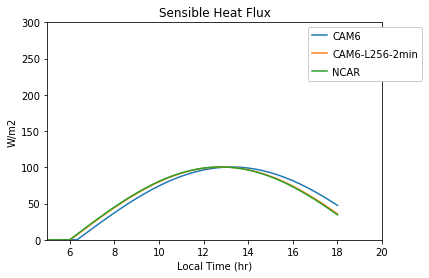

history/FSCAM.T42_T42.SAS.106def.cam.h0.2013-06-10-39600.nc
--  LHFLX  ---- PLOTTING 1D TIME PLOTS ------>>>   Latent Heat Flux
106def  --ymin/ymax -->  0.0 375.0719299316406
history/FSCAM.T42_T42.SAS.106d.cam.h0.2013-06-10-39600.nc
--  LHFLX  ---- PLOTTING 1D TIME PLOTS ------>>>   Latent Heat Flux
106d  --ymin/ymax -->  0.0 375.1499938964844
LES/patton_sas_stats.nc
None
wqsfc


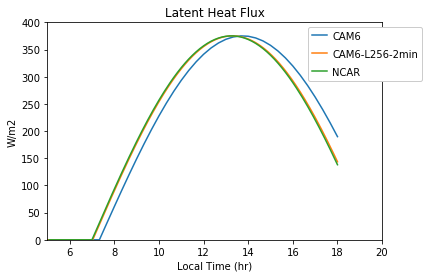

history/FSCAM.T42_T42.SAS.106def.cam.h0.2013-06-10-39600.nc
--  PBLH  ---- PLOTTING 1D TIME PLOTS ------>>>   Boundary Layer Depth
106def  --ymin/ymax -->  179.33358764648438 2384.283935546875
history/FSCAM.T42_T42.SAS.106d.cam.h0.2013-06-10-39600.nc
--  PBLH  ---- PLOTTING 1D TIME PLOTS ------>>>   Boundary Layer Depth
106d  --ymin/ymax -->  91.48234558105469 2668.95849609375
LES/patton_sas_stats.nc
None
zi_t


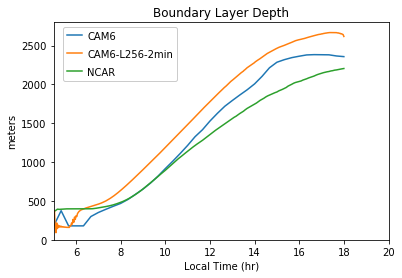

history/FSCAM.T42_T42.SAS.106def.cam.h0.2013-06-10-39600.nc
--  PBLH_DQ  ---- PLOTTING 1D TIME PLOTS ------>>>   Boundary Layer Depth (dq/dz max)
106def  --ymin/ymax -->  544.073557761435 2180.883271693626
history/FSCAM.T42_T42.SAS.106d.cam.h0.2013-06-10-39600.nc
--  PBLH_DQ  ---- PLOTTING 1D TIME PLOTS ------>>>   Boundary Layer Depth (dq/dz max)
106d  --ymin/ymax -->  413.74000624060375 1517.4871677425826
LES/patton_sas_stats.nc
None
zi_q


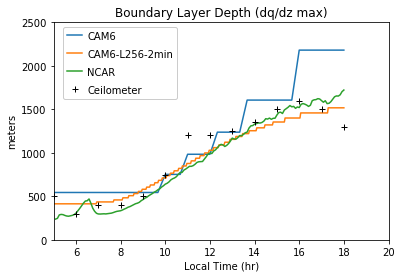

THV
---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  THV  -  Virtual Potential Temperature  -- cmin/cmax -->  295.0 305.0
Case =  106def Range= 297.994286371387 1292.23038547644
THV
Case =  106d Range= 298.28233744982776 1513.949426645471


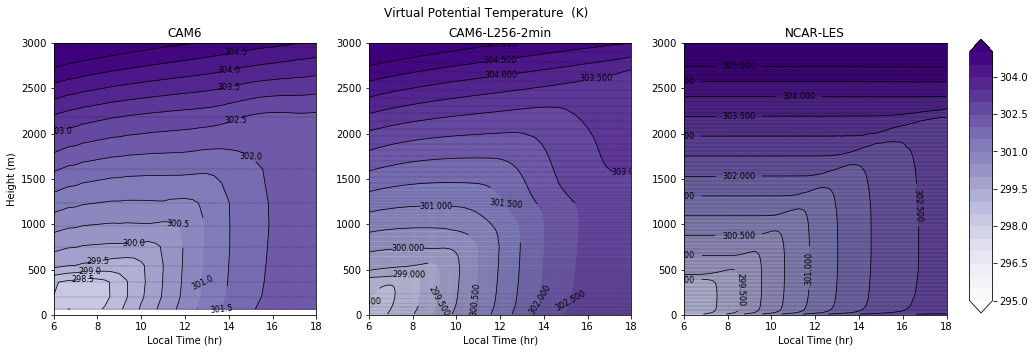

TH
---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  TH  -  Potential Temperature  -- cmin/cmax -->  295.0 305.0
Case =  106def Range= 295.8643794771507 1292.2282288379126
TH
Case =  106d Range= 296.15068718174587 1513.94689997399


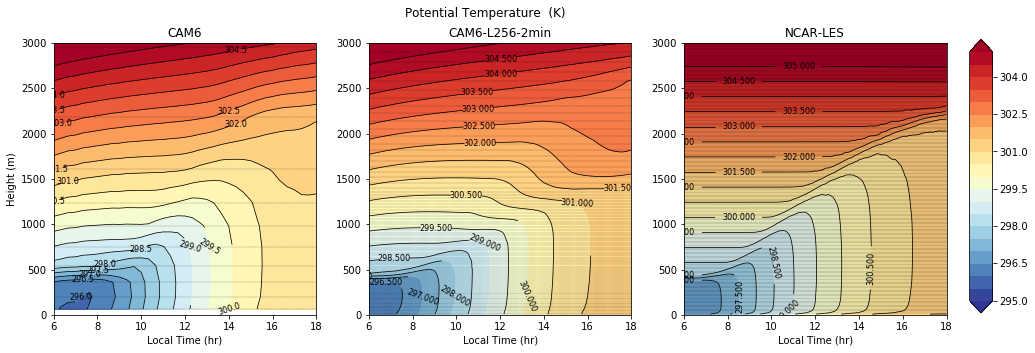

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  Q  -  Specific humidity  -- cmin/cmax -->  1.0 12.0
Case =  106def Range= 5.6155296e-11 0.012154632
Case =  106d Range= 5.1746678e-08 11.813239


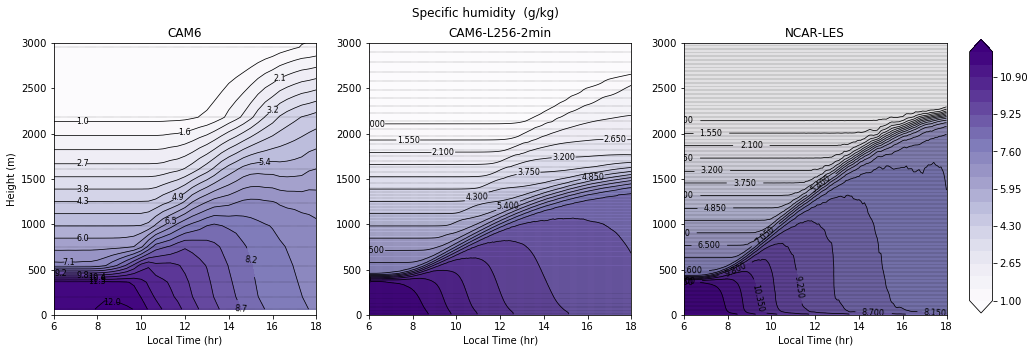

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WP2_CLUBB  -  Vertical Velocity Variance  -- cmin/cmax -->  0.0 2.0
Case =  106def Range= 0.0004 0.8159081
Case =  106d Range= 0.0004 0.9029179


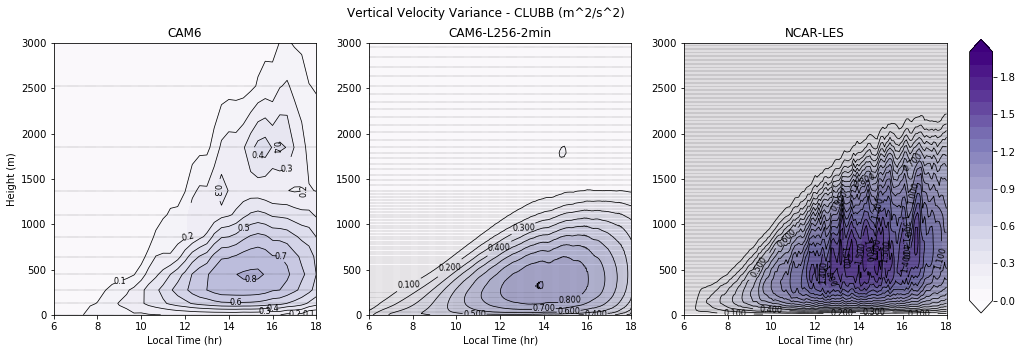

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WP3_CLUBB  -  Third Moment Vertical Velocity  -- cmin/cmax -->  0.0 0.5
Case =  106def Range= -0.0051014763 0.8886168
Case =  106d Range= -0.021550564 0.16489844


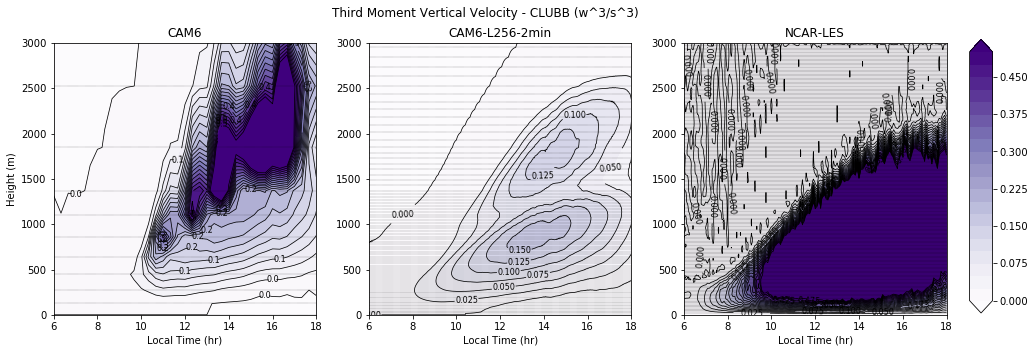

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WPTHLP_CLUBB  -  Heat Flux  -- cmin/cmax -->  -100.0 100.0
Case =  106def Range= -48.91202 101.753624
Case =  106d Range= -19.7061 101.15477


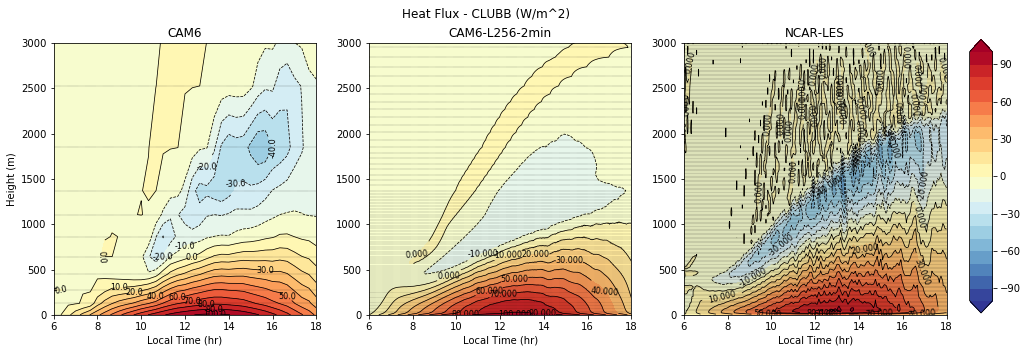

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WPRTP_CLUBB  -  Moisture Flux  -- cmin/cmax -->  -0.0 600.0
Case =  106def Range= -2.3322687 611.85846
Case =  106d Range= -0.040225666 446.16425


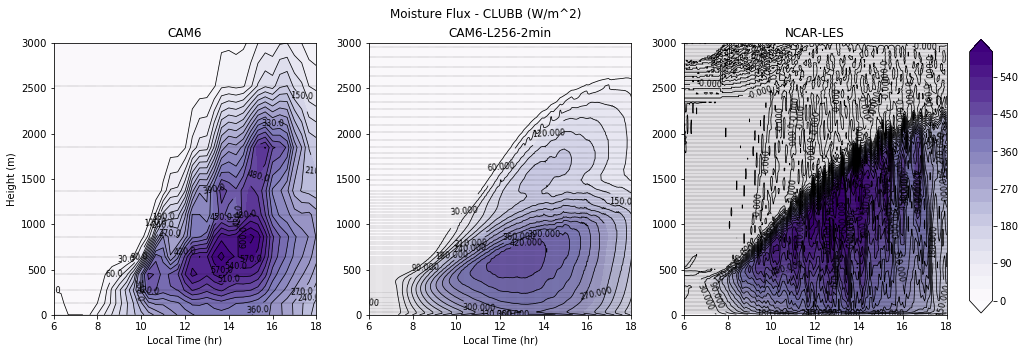

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  THLP2_CLUBB  -  Temperature Variance  -- cmin/cmax -->  0.0 0.05
Case =  106def Range= 1e-04 0.04658193
Case =  106d Range= 1e-04 0.028480137


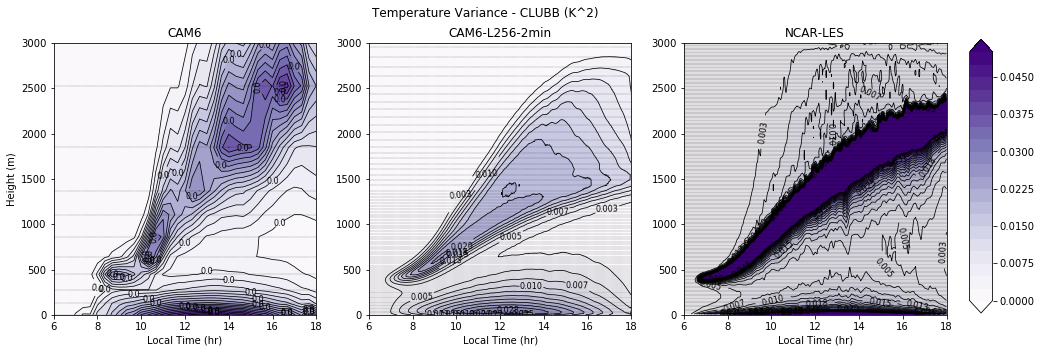

In [172]:
###### Plotting ##########
importlib.reload(mypy) # Required because I am constantly editing scam_func.py
#dir(mypy)

###### PLOTS ######

mypy.plot1d_ts_scam(run_info)   # 1D time series plots
mypy.plot2d_ts_scam(run_info)   # 2D time series plots
#mypy.plot1d_snap_scam(run_info)   # 1D snapshot plots
#mypy.plot1d_anim_scam(run_info) # 2D animation  plots
